<a href="https://colab.research.google.com/github/vsinyutsina/hft_final_qw/blob/main/%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9_%5B%D0%A7%D0%B0%D1%81%D1%82%D1%8C_1%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
df_hft_old = pd.read_csv('hft_data.csv')
df_hft_new = pd.read_csv('hft_data (1).csv')
df_hft = pd.concat([df_hft_old, df_hft_new])
df_hft.head()

,Datetime,Close,High,Low,Open,Volume,share_name,ticker_name
0,2025-02-03 14:30:00+00:00,410.720001,411.980011,409.119995,411.760010,1942143.0,Microsoft,MSFT
1,2025-02-03 14:31:00+00:00,411.290009,411.500000,410.000000,410.734985,174765.0,Microsoft,MSFT
2,2025-02-03 14:32:00+00:00,413.320007,413.320007,411.399994,411.399994,174173.0,Microsoft,MSFT
3,2025-02-03 14:33:00+00:00,412.850006,413.950012,412.850006,413.269989,162649.0,Microsoft,MSFT
4,2025-02-03 14:34:00+00:00,412.934998,413.160004,412.630005,412.804993,120189.0,Microsoft,MSFT


In [3]:
df_hft['Datetime'] = pd.to_datetime(df_hft['Datetime'])
df_hft['Datetime'] = df_hft['Datetime'].dt.tz_convert(None)

In [4]:
shares = {
            'Microsoft': 'MSFT',
            'Apple': 'AAPL',
            'NVIDIA': 'NVDA',
            'Amazon': 'AMZN',
            'Alphabet': 'GOOG',
            'Tesla': 'TSLA',
            'Broadcom': 'AVGO',
            'Meta': 'META',
            'Costco': 'COST',
            'Netflix': 'NFLX'
        }
crypto = {
            'Bitcoin': 'BTC',
            'Ethereum': 'ETH',
            'Tether': 'USDT',
            'Binance': 'BNB',
            'Solana': 'SOL',
            'USD': 'USDC',
            'XRP': 'XRP',
            'Cardano': 'ADA',
            'Dogecoin': 'DOGE',
            'Toncoin': 'TON'
        }

In [5]:
df_shares = pd.DataFrame(shares.items(), columns=['share_name', 'ticker_name'])
df_crypto = pd.DataFrame(crypto.items(), columns=['share_name', 'ticker_name'])

df_shares = pd.concat([df_shares, df_crypto])
df_shares['key'] = 1
df_shares.head()

,share_name,ticker_name,key
0,Microsoft,MSFT,1
1,Apple,AAPL,1
2,NVIDIA,NVDA,1
3,Amazon,AMZN,1
4,Alphabet,GOOG,1


In [6]:
start = datetime(2025, 2, 1)
end = datetime(2025, 3, 1)
delta = timedelta(minutes=1)

date_list = [start + i * delta for i in range(int((end - start) / delta) + 1)]

df_calendar = pd.DataFrame(date_list, columns=['Datetime'])
df_calendar['key'] = 1
df_calendar.head()

,Datetime,key
0,2025-02-01 00:00:00,1
1,2025-02-01 00:01:00,1
2,2025-02-01 00:02:00,1
3,2025-02-01 00:03:00,1
4,2025-02-01 00:04:00,1


In [7]:
df_calendar = df_calendar.merge(df_shares, on='key')
df_calendar = df_calendar.drop('key', axis=1)

In [8]:
df_calendar.head()

,Datetime,share_name,ticker_name
0,2025-02-01,Microsoft,MSFT
1,2025-02-01,Apple,AAPL
2,2025-02-01,NVIDIA,NVDA
3,2025-02-01,Amazon,AMZN
4,2025-02-01,Alphabet,GOOG


# Подготовка данных к обучению

In [9]:
df = df_calendar.merge(df_hft, how='left', on=['Datetime', 'share_name', 'ticker_name'])

df['Date'] = df.Datetime.dt.date
df = df.loc[df['Date'] > date(2025, 2, 3), :]
df.head()

,Datetime,share_name,ticker_name,Close,High,Low,Open,Volume,Date
86400,2025-02-04,Microsoft,MSFT,NaN,NaN,NaN,NaN,NaN,2025-02-04
86401,2025-02-04,Apple,AAPL,NaN,NaN,NaN,NaN,NaN,2025-02-04
86402,2025-02-04,NVIDIA,NVDA,NaN,NaN,NaN,NaN,NaN,2025-02-04
86403,2025-02-04,Amazon,AMZN,NaN,NaN,NaN,NaN,NaN,2025-02-04
86404,2025-02-04,Alphabet,GOOG,NaN,NaN,NaN,NaN,NaN,2025-02-04


## Заполняем пропуски в данных

In [10]:
df = df.sort_values(['ticker_name', 'Datetime'])

df['Close'] = df.groupby('ticker_name')['Close'].ffill().bfill()
df['High'] = df.groupby('ticker_name')['Close'].ffill().bfill()
df['Low'] = df.groupby('ticker_name')['Close'].ffill().bfill()
df['Open'] = df.groupby('ticker_name')['Close'].ffill().bfill()
df['working_hours'] = 1
df.loc[df['Volume'].isna(), 'working_hours'] = 0
df.loc[df['Volume'].isna(), 'Volume'] = 0

In [11]:
df = df[~df.Close.isna()] #Отсекаем все, что не заполнилось, потому что там и нечему заполняться
df.reset_index(inplace=True, drop=True)

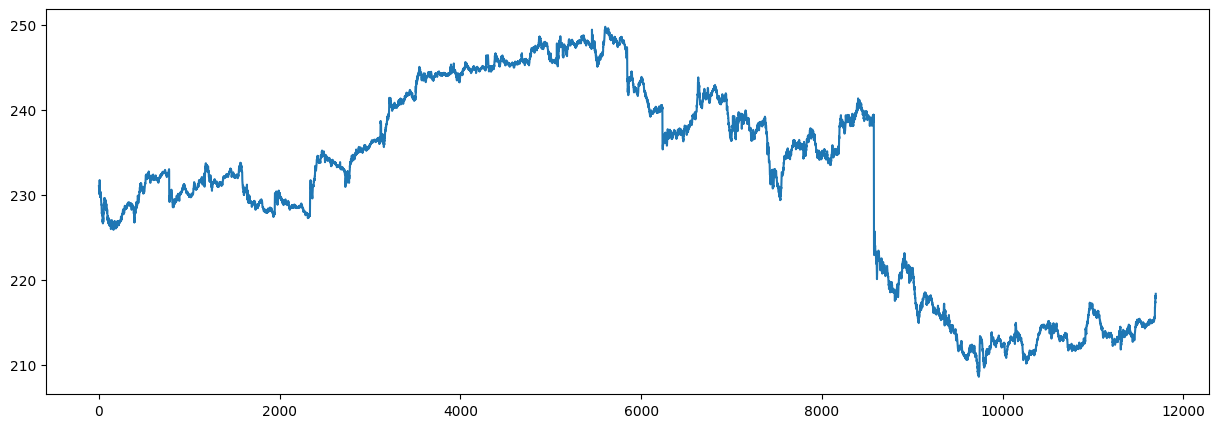

In [12]:
# График, если убрать дни, когда биржа не работала
plt.figure(figsize=(15, 5))

plt.plot(df_hft.query('(share_name == "Apple")').reset_index().Close)

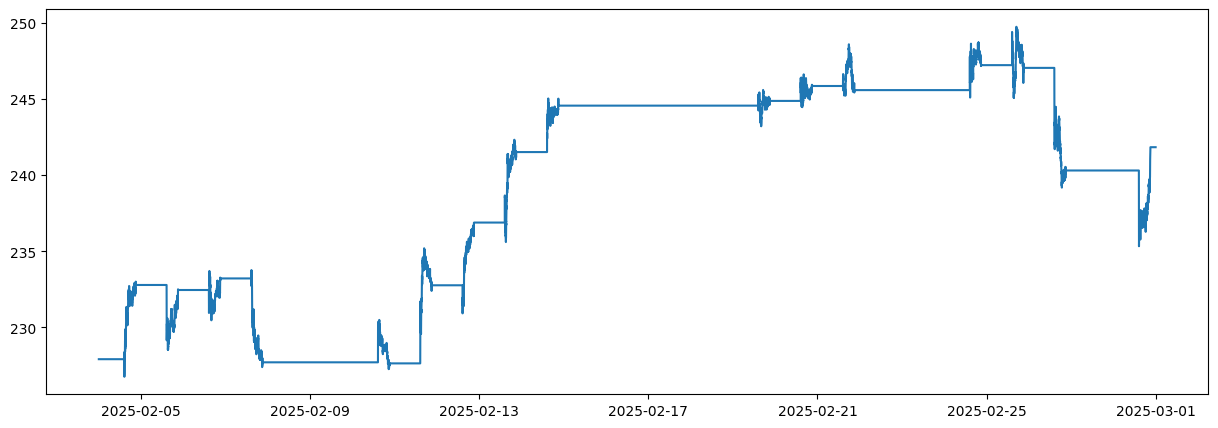

In [13]:
# График, если НЕ убирать дни, когда биржа не работала

plt.figure(figsize=(15, 5))

plt.plot(df.query('(share_name == "Apple")').set_index('Datetime').Close)

Как будто датафрейм с обработанными выбросами не стоит использовать для обучения модели. Предлагаю обучаться на данных без привязки к дате. Важно сохранить именно последовательность.

## Добавляем таргет к датафрейму

In [14]:
df_hft['Close_prev'] = df_hft.groupby(['share_name', 'ticker_name']).Close.shift(1)
df = df_hft[~df_hft.Close_prev.isna()]

df = df.copy()
df['target_abs'] = df['Close'] - df['Close_prev']
df['target_ratio'] = df['target_abs']/df['Close_prev']
df = df.query('ticker_name != "USDC"')

df['target'] = df.groupby('ticker_name').target_ratio.shift(-1)

df.head()

,Datetime,Close,High,Low,Open,Volume,share_name,ticker_name,Close_prev,target_abs,target_ratio,target
1,2025-02-03 14:31:00,411.290009,411.500000,410.000000,410.734985,174765.0,Microsoft,MSFT,410.720001,0.570007,0.001388,0.004936
2,2025-02-03 14:32:00,413.320007,413.320007,411.399994,411.399994,174173.0,Microsoft,MSFT,411.290009,2.029999,0.004936,-0.001137
3,2025-02-03 14:33:00,412.850006,413.950012,412.850006,413.269989,162649.0,Microsoft,MSFT,413.320007,-0.470001,-0.001137,0.000206
4,2025-02-03 14:34:00,412.934998,413.160004,412.630005,412.804993,120189.0,Microsoft,MSFT,412.850006,0.084991,0.000206,0.002874
5,2025-02-03 14:35:00,414.121613,414.399994,412.649994,413.029999,245168.0,Microsoft,MSFT,412.934998,1.186615,0.002874,-0.001235


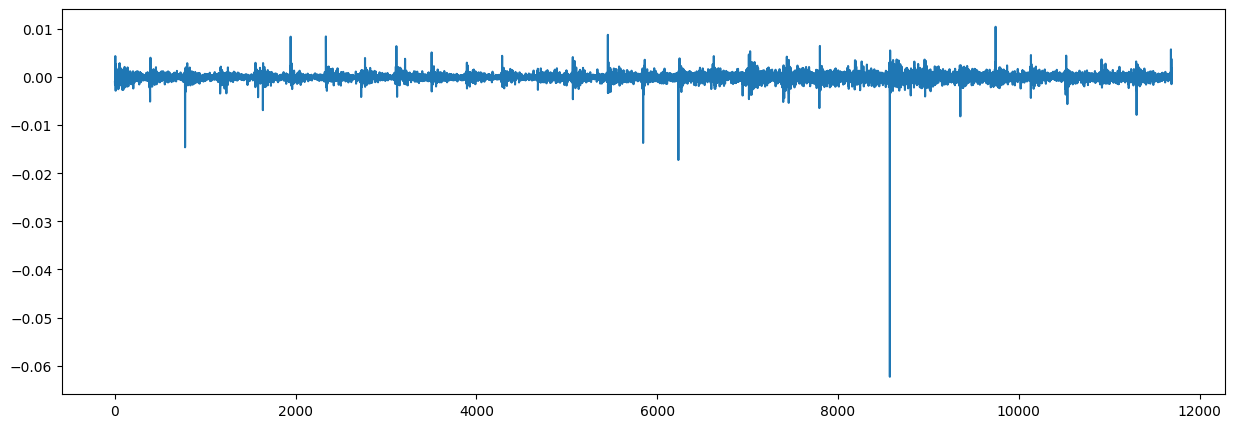

In [15]:
plt.figure(figsize=(15, 5))

plt.plot(df.query('(share_name == "Apple")').reset_index().target)

## Трейн и тест

In [16]:
def train_test_series_split(series, test_size=0.2):

    train_size = int(len(series) * (1 - test_size))
    train, test = series[:train_size], series[train_size:]

    return train, test

# Обучение простых моделей
## Статистические модели
### Экспоненциальное сглаживание

In [17]:
import pandas as pd
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing


def train_and_predict_ses(series, test_size=0.2):

    train, test = train_test_series_split(series, test_size=0.2)

    model = SimpleExpSmoothing(series)
    model_fit = model.fit(optimized=True)

    forecast = model_fit.forecast(steps=len(test))
    rmse = sqrt(mean_squared_error(test, forecast))

    return forecast, rmse


def train_and_predict_holt(series, test_size=0.2):

    train, test = train_test_series_split(series, test_size=0.2)

    model = Holt(series)
    model_fit = model.fit(optimized=True)

    forecast = model_fit.forecast(steps=len(test))
    rmse = sqrt(mean_squared_error(test, forecast))

    return forecast, rmse


def train_and_predict_hw(series, test_size=0.2):

    train, test = train_test_series_split(series, test_size=0.2)

    model = ExponentialSmoothing(series, seasonal_periods=60,
                                 trend='add', seasonal='add')  # seasonal_periods = период сезонности
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=len(test))
    rmse = sqrt(mean_squared_error(test, forecast))

    return forecast, rmse

In [18]:
# Группируем данные по ticker_name
grouped = df.groupby('ticker_name')['target_ratio']

# Создаем словарь для хранения результатов
results = {}

# Итерируемся по каждой группе (акции) и обучаем модель
for ticker, series in grouped:
    print(f"Обучение модели для {ticker}...")
    predictions, rmse = train_and_predict_ses(series)
    results[ticker] = {'predictions': predictions, 'rmse': rmse}
    print(f"RMSE для {ticker}: {rmse:.4f}")
    print("-" * 20)

Обучение модели для AAPL...
RMSE для AAPL: 0.0008
--------------------
Обучение модели для AMZN...
RMSE для AMZN: 0.0011
--------------------
Обучение модели для AVGO...
RMSE для AVGO: 0.0016
--------------------
Обучение модели для BTC...
RMSE для BTC: 0.0017
--------------------
Обучение модели для COST...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

RMSE для COST: 0.0008
--------------------
Обучение модели для ETH...
RMSE для ETH: 0.0017
--------------------
Обучение модели для GOOG...
RMSE для GOOG: 0.0008
--------------------
Обучение модели для META...
RMSE для META: 0.0012
--------------------
Обучение модели для MSFT...
RMSE для MSFT: 0.0007
--------------------
Обучение модели для NFLX...
RMSE для NFLX: 0.0013
--------------------
Обучение модели для NVDA...
RMSE для NVDA: 0.0014
--------------------
Обучение модели для SOL...
RMSE для SOL: 0.0104
--------------------
Обучение модели для TSLA...
RMSE для TSLA: 0.0022
--------------------


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

In [19]:
df_result = pd.DataFrame([(ticker, result['rmse']) for ticker, result in results.items()],
                         columns=['ticker_name', 'rmse_ses'])
df_result

,ticker_name,rmse_ses
0,AAPL,0.000818
1,AMZN,0.001057
2,AVGO,0.001580
3,BTC,0.001703
4,COST,0.000761
5,ETH,0.001706
6,GOOG,0.000808
7,META,0.001186
8,MSFT,0.000666
9,NFLX,0.001295


### Хольт

In [20]:
# Группируем данные по ticker_name
grouped = df.groupby('ticker_name')['target_ratio']

# Создаем словарь для хранения результатов
results = {}

# Итерируемся по каждой группе (акции) и обучаем модель
for ticker, series in grouped:
    print(f"Обучение модели для {ticker}...")
    predictions, rmse = train_and_predict_holt(series)
    results[ticker] = {'predictions': predictions, 'rmse': rmse}
    print(f"RMSE для {ticker}: {rmse:.4f}")
    print("-" * 20)

Обучение модели для AAPL...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

RMSE для AAPL: 0.0238
--------------------
Обучение модели для AMZN...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE для AMZN: 0.0044
--------------------
Обучение модели для AVGO...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE для AVGO: 0.0579
--------------------
Обучение модели для BTC...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE для BTC: 0.0056
--------------------
Обучение модели для COST...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE для COST: 0.0039
--------------------
Обучение модели для ETH...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE для ETH: 0.0021
--------------------
Обучение модели для GOOG...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE для GOOG: 0.0159
--------------------
Обучение модели для META...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE для META: 0.0521
--------------------
Обучение модели для MSFT...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE для MSFT: 0.0783
--------------------
Обучение модели для NFLX...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE для NFLX: 0.0210
--------------------
Обучение модели для NVDA...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE для NVDA: 0.0352
--------------------
Обучение модели для SOL...
RMSE для SOL: 0.0662
--------------------
Обучение модели для TSLA...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE для TSLA: 0.0342
--------------------


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [21]:
df_result_holt = pd.DataFrame([(ticker, result['rmse']) for ticker, result in results.items()],
                              columns=['ticker_name', 'rmse_holt'])
df_result = df_result.merge(df_result_holt, on='ticker_name')
df_result

,ticker_name,rmse_ses,rmse_holt
0,AAPL,0.000818,0.023810
1,AMZN,0.001057,0.004423
2,AVGO,0.001580,0.057920
3,BTC,0.001703,0.005639
4,COST,0.000761,0.003929
5,ETH,0.001706,0.002087
6,GOOG,0.000808,0.015949
7,META,0.001186,0.052137
8,MSFT,0.000666,0.078284
9,NFLX,0.001295,0.020951


### Хольт-Винтерс

In [22]:
# Группируем данные по ticker_name
grouped = df.groupby('ticker_name')['target_ratio']

# Создаем словарь для хранения результатов
results = {}

# Итерируемся по каждой группе (акции) и обучаем модель
for ticker, series in grouped:
    print(f"Обучение модели для {ticker}...")
    predictions, rmse = train_and_predict_hw(series)
    results[ticker] = {'predictions': predictions, 'rmse': rmse}
    print(f"RMSE для {ticker}: {rmse:.4f}")
    print("-" * 20)

Обучение модели для AAPL...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

RMSE для AAPL: 0.0008
--------------------
Обучение модели для AMZN...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE для AMZN: 0.0011
--------------------
Обучение модели для AVGO...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE для AVGO: 0.0016
--------------------
Обучение модели для BTC...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE для BTC: 0.0017
--------------------
Обучение модели для COST...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE для COST: 0.0008
--------------------
Обучение модели для ETH...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE для ETH: 0.0017
--------------------
Обучение модели для GOOG...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

RMSE для GOOG: 0.0008
--------------------
Обучение модели для META...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE для META: 0.0012
--------------------
Обучение модели для MSFT...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE для MSFT: 0.0007
--------------------
Обучение модели для NFLX...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE для NFLX: 0.0013
--------------------
Обучение модели для NVDA...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

RMSE для NVDA: 0.0015
--------------------
Обучение модели для SOL...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE для SOL: 0.0104
--------------------
Обучение модели для TSLA...
RMSE для TSLA: 0.0022
--------------------


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [23]:
df_result_hw = pd.DataFrame([(ticker, result['rmse']) for ticker, result in results.items()],
                              columns=['ticker_name', 'rmse_hw'])
df_result = df_result.merge(df_result_hw, on='ticker_name')
df_result

,ticker_name,rmse_ses,rmse_holt,rmse_hw
0,AAPL,0.000818,0.023810,0.000831
1,AMZN,0.001057,0.004423,0.001070
2,AVGO,0.001580,0.057920,0.001591
3,BTC,0.001703,0.005639,0.001719
4,COST,0.000761,0.003929,0.000768
5,ETH,0.001706,0.002087,0.001720
6,GOOG,0.000808,0.015949,0.000797
7,META,0.001186,0.052137,0.001194
8,MSFT,0.000666,0.078284,0.000652
9,NFLX,0.001295,0.020951,0.001296



### SARIMAX

In [24]:
# Функция для обучения и прогнозирования SARIMAX для одного ряда
def train_and_predict_sarimax(series, order, seasonal_order, test_size=0.2):

    train, test = train_test_series_split(series, test_size=0.2)

    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)  # disp=False для подавления вывода
    predictions = model_fit.forecast(steps=len(test))
    rmse = sqrt(mean_squared_error(test, predictions))

    return predictions, rmse

In [25]:
# # Группируем данные по ticker_name
# grouped = df.groupby('ticker_name')['target_ratio']

# # Создаем словарь для хранения результатов
# results = {}

# order = (1, 1, 0)
# seasonal_order = (1, 1, 0, 60)

# # Итерируемся по каждой группе (акции) и обучаем модель
# for ticker, series in grouped:
#     print(f"Обучение модели для {ticker}...")
#     predictions, rmse = train_and_predict_sarimax(series, order, seasonal_order)
#     results[ticker] = {'predictions': predictions, 'rmse': rmse}
#     print(f"RMSE для {ticker}: {rmse:.4f}")
#     print("-" * 20)

In [26]:
df_sarimax = pd.read_csv('df_result.csv')

df_result = df_result.merge(df_sarimax, on='ticker_name')
df_result

,ticker_name,rmse_ses,rmse_holt,rmse_hw,rmse_sarimax
0,AAPL,0.000818,0.023810,0.000831,0.001730
1,AMZN,0.001057,0.004423,0.001070,0.004263
2,AVGO,0.001580,0.057920,0.001591,0.006370
3,BTC,0.001703,0.005639,0.001719,0.005152
4,COST,0.000761,0.003929,0.000768,0.006334
5,ETH,0.001706,0.002087,0.001720,0.005232
6,GOOG,0.000808,0.015949,0.000797,0.001420
7,META,0.001186,0.052137,0.001194,0.002923
8,MSFT,0.000666,0.078284,0.000652,0.001892
9,NFLX,0.001295,0.020951,0.001296,0.009401


## Классический ML
### Генерируем новые признаки

In [27]:
df_classic = df.copy()
df_classic.head()

,Datetime,Close,High,Low,Open,Volume,share_name,ticker_name,Close_prev,target_abs,target_ratio,target
1,2025-02-03 14:31:00,411.290009,411.500000,410.000000,410.734985,174765.0,Microsoft,MSFT,410.720001,0.570007,0.001388,0.004936
2,2025-02-03 14:32:00,413.320007,413.320007,411.399994,411.399994,174173.0,Microsoft,MSFT,411.290009,2.029999,0.004936,-0.001137
3,2025-02-03 14:33:00,412.850006,413.950012,412.850006,413.269989,162649.0,Microsoft,MSFT,413.320007,-0.470001,-0.001137,0.000206
4,2025-02-03 14:34:00,412.934998,413.160004,412.630005,412.804993,120189.0,Microsoft,MSFT,412.850006,0.084991,0.000206,0.002874
5,2025-02-03 14:35:00,414.121613,414.399994,412.649994,413.029999,245168.0,Microsoft,MSFT,412.934998,1.186615,0.002874,-0.001235


**Список новых признаков:**
1. Временные признаки
  - День
  - День недели
  - Минута
  - Час
2. Лаговые признаки
  - t-1, t-2, t-3, t-5, t-10, t-30, t-60
  - Скользящие средние (Moving Averages)
  - Отклонение от скользящей средней
  - Разности (Differences)
3. Статистические признаки (Statistical Features)
4. Fourier Transform Features


In [68]:
def calculate_fft_features(series, window_size):
    """
    Вычисляет признаки на основе FFT для скользящего окна.

    Args:
        series (pd.Series):  Временной ряд.
        window_size (int):  Размер скользящего окна.

    Returns:
        pd.DataFrame:  DataFrame с признаками (амплитуды и фазы).
    """

    amplitudes_list = []
    phases_list = []

    for i in range(len(series) - window_size + 1):
        window = series[i:i + window_size].values
        windowed = window * np.hanning(window_size) # Применение оконной функции
        fft = np.fft.fft(windowed)
        fft_abs = np.abs(fft)
        fft_angle = np.angle(fft)

        amplitudes_list.append(fft_abs)
        phases_list.append(fft_angle)


    # Преобразование списков NumPy массивов в DataFrame
    df = pd.DataFrame()
    df['amplitudes'] = amplitudes_list
    df['phases'] = phases_list

    return df

In [28]:
def new_time_features(data):
  data['minute'] = data.Datetime.dt.minute
  data['hour'] = data.Datetime.dt.hour
  data['day'] = data.Datetime.dt.day
  data['weekday'] = data.Datetime.dt.weekday

  d_time = [('minute', 60), ('hour', 24), ('day', 31), ('weekday', 7)]

  for col_name, period in d_time:
    data[col_name + '_sin'] = np.sin(2 * np.pi * data[col_name] / period)
    data[col_name + '_cos'] = np.cos(2 * np.pi * data[col_name] / period)
    data[col_name] = data[col_name].apply(str)

  return data


def new_lag_and_statistic_features(data):
  lags = [1, 2, 3, 5, 15, 30, 60]

  for lag in lags:
    data['ratio_lag_' + str(lag)] = data.target_ratio.shift(lag)
    data['ratio_diff_lag_' + str(lag)] = data.target_ratio - data['ratio_lag_' + str(lag)]
    data['ratio_mean_lag_' + str(lag)] = data.groupby('ticker_name').target_ratio.transform(lambda x: x.rolling(lag, min_periods=1).mean())
    data['ratio_diff_mean_lag_' + str(lag)] = data.target_ratio - data['ratio_mean_lag_' + str(lag)]
    data['ratio_exp_mean_lag_' + str(lag)] = data.groupby('ticker_name').target_ratio.transform(lambda x: x.ewm(alpha=lag/100, min_periods=1).mean())

  for lag in lags[3:]:
    data['ratio_max_lag_' + str(lag)] = data.groupby('ticker_name').target_ratio.transform(lambda x: x.rolling(lag, min_periods=1).max())
    data['ratio_min_lag_' + str(lag)] = data.groupby('ticker_name').target_ratio.transform(lambda x: x.rolling(lag, min_periods=1).min())
    data['ratio_q25_lag_' + str(lag)] = data.groupby('ticker_name').target_ratio.transform(lambda x: x.rolling(lag, min_periods=1).quantile(0.25))
    data['ratio_q75_lag_' + str(lag)] = data.groupby('ticker_name').target_ratio.transform(lambda x: x.rolling(lag, min_periods=1).quantile(0.75))

  return data


def new_fft_features(data):

  grouped = data.groupby('ticker_name').target_ratio
  lags = [5, 15, 30, 60]
  res = []
  for ticker, series in grouped:

    for lag in lags:
      tmp = calculate_fft_features(series, lag)
      tmp['ticker'] = ticker
      res.append(tmp)

  return pd.concat(res)

In [29]:
df_classic = new_time_features(df_classic)
df_classic.head()

,Datetime,Close,High,Low,Open,Volume,share_name,ticker_name,Close_prev,target_abs,...,day,weekday,minute_sin,minute_cos,hour_sin,hour_cos,day_sin,day_cos,weekday_sin,weekday_cos
1,2025-02-03 14:31:00,411.290009,411.500000,410.000000,410.734985,174765.0,Microsoft,MSFT,410.720001,0.570007,...,3,0,-0.104528,-0.994522,-0.5,-0.866025,0.571268,0.820763,0.0,1.0
2,2025-02-03 14:32:00,413.320007,413.320007,411.399994,411.399994,174173.0,Microsoft,MSFT,411.290009,2.029999,...,3,0,-0.207912,-0.978148,-0.5,-0.866025,0.571268,0.820763,0.0,1.0
3,2025-02-03 14:33:00,412.850006,413.950012,412.850006,413.269989,162649.0,Microsoft,MSFT,413.320007,-0.470001,...,3,0,-0.309017,-0.951057,-0.5,-0.866025,0.571268,0.820763,0.0,1.0
4,2025-02-03 14:34:00,412.934998,413.160004,412.630005,412.804993,120189.0,Microsoft,MSFT,412.850006,0.084991,...,3,0,-0.406737,-0.913545,-0.5,-0.866025,0.571268,0.820763,0.0,1.0
5,2025-02-03 14:35:00,414.121613,414.399994,412.649994,413.029999,245168.0,Microsoft,MSFT,412.934998,1.186615,...,3,0,-0.500000,-0.866025,-0.5,-0.866025,0.571268,0.820763,0.0,1.0


In [30]:
df_classic = new_lag_and_statistic_features(df_classic)
df_classic.head()

,Datetime,Close,High,Low,Open,Volume,share_name,ticker_name,Close_prev,target_abs,...,ratio_q25_lag_15,ratio_q75_lag_15,ratio_max_lag_30,ratio_min_lag_30,ratio_q25_lag_30,ratio_q75_lag_30,ratio_max_lag_60,ratio_min_lag_60,ratio_q25_lag_60,ratio_q75_lag_60
1,2025-02-03 14:31:00,411.290009,411.500000,410.000000,410.734985,174765.0,Microsoft,MSFT,410.720001,0.570007,...,0.001388,0.001388,0.001388,0.001388,0.001388,0.001388,0.001388,0.001388,0.001388,0.001388
2,2025-02-03 14:32:00,413.320007,413.320007,411.399994,411.399994,174173.0,Microsoft,MSFT,411.290009,2.029999,...,0.002275,0.004049,0.004936,0.001388,0.002275,0.004049,0.004936,0.001388,0.002275,0.004049
3,2025-02-03 14:33:00,412.850006,413.950012,412.850006,413.269989,162649.0,Microsoft,MSFT,413.320007,-0.470001,...,0.000125,0.003162,0.004936,-0.001137,0.000125,0.003162,0.004936,-0.001137,0.000125,0.003162
4,2025-02-03 14:34:00,412.934998,413.160004,412.630005,412.804993,120189.0,Microsoft,MSFT,412.850006,0.084991,...,-0.000130,0.002275,0.004936,-0.001137,-0.000130,0.002275,0.004936,-0.001137,-0.000130,0.002275
5,2025-02-03 14:35:00,414.121613,414.399994,412.649994,413.029999,245168.0,Microsoft,MSFT,412.934998,1.186615,...,0.000206,0.002874,0.004936,-0.001137,0.000206,0.002874,0.004936,-0.001137,0.000206,0.002874


In [31]:
mask = ~df_classic.columns.isin(['Datetime', 'target', 'share_name', 'ticker_name'])
mask

array([False,  True,  True,  True,  True,  True, False, False,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet


X = df_classic.drop('target', axis=1)
y = df_classic['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# Убедитесь, что mask содержит булевы значения для числовых столбцов
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()  # Автоматический выбор числовых столбцов
categorical_features = ['ticker_name']

# Создайте трансформеры
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Для плотного массива

# Конфигурация ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Лучше явно указать ненужные столбцы
)

# Создайте пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regression', LinearRegression())
])

# Проверьте данные перед обучением
print("Проверка столбцов в X_train:", X_train.columns.tolist())
print("Числовые столбцы:", numeric_features)
print("Категориальные столбцы:", categorical_features)

# Запустите обучение
pipeline.fit(X_train, y_train)

Проверка столбцов в X_train: ['Datetime', 'Close', 'High', 'Low', 'Open', 'Volume', 'share_name', 'ticker_name', 'Close_prev', 'target_abs', 'target_ratio', 'minute', 'hour', 'day', 'weekday', 'minute_sin', 'minute_cos', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'ratio_lag_1', 'ratio_diff_lag_1', 'ratio_mean_lag_1', 'ratio_diff_mean_lag_1', 'ratio_exp_mean_lag_1', 'ratio_lag_2', 'ratio_diff_lag_2', 'ratio_mean_lag_2', 'ratio_diff_mean_lag_2', 'ratio_exp_mean_lag_2', 'ratio_lag_3', 'ratio_diff_lag_3', 'ratio_mean_lag_3', 'ratio_diff_mean_lag_3', 'ratio_exp_mean_lag_3', 'ratio_lag_5', 'ratio_diff_lag_5', 'ratio_mean_lag_5', 'ratio_diff_mean_lag_5', 'ratio_exp_mean_lag_5', 'ratio_lag_15', 'ratio_diff_lag_15', 'ratio_mean_lag_15', 'ratio_diff_mean_lag_15', 'ratio_exp_mean_lag_15', 'ratio_lag_30', 'ratio_diff_lag_30', 'ratio_mean_lag_30', 'ratio_diff_mean_lag_30', 'ratio_exp_mean_lag_30', 'ratio_lag_60', 'ratio_diff_lag_60', 'ratio_mean_lag_60', 'ratio_diff

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [58]:
df_classic.isna().sum().sum()

np.int64(245)

In [59]:
lr_model = LinearRegression().fit(X_train, y_train)

TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [41]:
# 1. Подготовка данных

# Пример данных (замените на свой набор данных)
data = {
    'Возраст': [25, 30, 22, 35, 28],
    'Пол': ['Мужской', 'Женский', 'Мужской', 'Женский', 'Мужской'],
    'Доход': [50000, 60000, 45000, 70000, 55000],
    'Образование': ['Высшее', 'Среднее', 'Высшее', 'Высшее', 'Среднее'],
    'Целевая переменная': [1, 0, 1, 0, 1]  # 1 - клиент купил продукт, 0 - не купил
}
df = pd.DataFrame(data)

# Разделение на признаки (X) и целевую переменную (y)
X = df.drop('Целевая переменная', axis=1)
y = df['Целевая переменная']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train

,Целевая переменная
4,1
2,1
0,1
3,0
